In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import mlflow
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(mlflow.__version__)
print(tf.__version__)

2.11.1
2.16.1


In [0]:
# Discriminator

class Discriminator(tf.keras.Model):
    def __init__(self, input_dim, discriminator_dim, num_classes, pac = 10):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.pac = pac
        self.pacdim = input_dim * pac
        self.seq = tf.keras.Sequential()
        
        for item in discriminator_dim:
            self.seq.add(layers.Dense(item))
            self.seq.add(layers.LeakyReLU(0.2))
            self.seq.add(layers.Dropout(0.5))
            
        self.seq.add(layers.Dense(1)) # Output dimension is 1 for binary classification


    def call(self, input_data, classes, training=True):
        # Combine data and labels
        combined_input = tf.concat([input_data, classes], axis=-1)
        tf.debugging.assert_equal(tf.shape(combined_input)[0] % self.pac, 0, message="The input batch size is not divisible by pac.")
        combined_input = tf.reshape(combined_input, (-1, self.pacdim))
        return self.seq(combined_input, training=training)


In [0]:
# Generator 
class Residual(tf.keras.Model):
    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = layers.Dense(o)
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, input_, training=True):
        x = self.fc(input_)
        x = self.bn(x, training=training)
        x = self.relu(x)
        return tf.concat([x, input_], axis=-1)

class Generator(tf.keras.Model):
    def __init__(self, embedding_dim, generator_dim, num_features, num_classes):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.num_features = num_features
        self.label_embedding = layers.Embedding(num_classes, embedding_dim)

        # Define the generator's layers
        self.seq = tf.keras.Sequential()
        # Adjust the input dimension to account for the concatenated noise and label embeddings
        total_input_dim = embedding_dim + num_classes  # Adjust this based on how you're processing labels

        # Define the generator's architecture
        for dim in generator_dim:
            self.seq.add(layers.Dense(dim, activation='relu'))
        # The final layer should match the data_dim
        self.seq.add(layers.Dense(num_features))

    def call(self, noise, classes, training=True):
        label_embedding = self.label_embedding(classes)

        # Flatten or reshape the label_embedding if it's not already [batch_size, embedding_dim * num_classes]
        label_embedding = tf.reshape(label_embedding, [tf.shape(label_embedding)[0], -1])
        combined_input = tf.concat([noise, label_embedding], axis=-1)
        return self.seq(combined_input, training=training)


## Loss Functions and Gradient Penality

In [0]:
# Loss Functions and Gradient Penality
def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def gradient_penalty(discriminator, batch_size, real_data, fake_data):
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = alpha * real_data + (1 - alpha) * fake_data

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    gp = tf.reduce_mean((norm - 1.) ** 2)
    return gp


## Training Step Function

In [0]:
@tf.function
def train_step(real_data, classes, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim):
    current_batch_size = tf.shape(classes)[0]  # Dynamically determine the batch size
    # Convert class labels to one-hot
    classes = tf.one_hot(classes, depth=num_classes)

    noise = tf.random.normal([current_batch_size, noise_dim])

    # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake data
        fake_data = generator(noise, classes, training=True)

        # Get discriminator outputs for real and fake data
        real_output = discriminator(real_data, classes, training=True)
        fake_output = discriminator(fake_data, classes, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Ensure the losses are scalar
        if not gen_loss.shape == () or not disc_loss.shape == ():
            raise ValueError("Losses must be scalar values.")

    # Get gradients and apply them
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Check for any None gradients
    if None in gradients_of_generator or None in gradients_of_discriminator:
        raise ValueError("Found None in gradients. The computational graph might be broken.")

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

## Load dataset

In [0]:
# Load and preprocess the dataset
def load_preprocess_dataset(path):
    # Load the dataset
    df = pd.read_csv(path, index_col=0).reset_index()
    df = df.dropna()

    # Separate features and labels
    X_scaled = df.drop('Attack_type', axis=1)
    y = df['Attack_type']

    # Encode labels as integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X_scaled, y_encoded, label_encoder.classes_


In [0]:
# Load dataset 
processed_file_path = '/dbfs/FileStore/m332479/GANs_forCyberSecurity/processed_RT_IOT2022.csv'
X, y, classes = load_preprocess_dataset(processed_file_path)
num_classes, num_features = len(classes), X.shape[1]
num_classes, num_features

(10, 40)

## Split Dataset

In [0]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [0]:
# Assuming 'features' and 'labels' are your DataFrame columns for input features and target labels
batch_size = 500

dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
dataset = dataset.shuffle(buffer_size=len(X_train))
dataset = dataset.batch(batch_size, drop_remainder=True)  # Drop the last smaller batch
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [0]:
epochs = 100
embedding_dim = 128
noise_dim = 128
discriminator_dim = (256, 256)
generator_dim = (256, 256)
pac = 10
generator_lr = 2e-4
discriminator_lr = 2e-4
# Within the CTGAN fit method
generator = Generator(embedding_dim=noise_dim, generator_dim=generator_dim, num_features=num_features, num_classes=num_classes)
discriminator = Discriminator(input_dim=num_features + num_classes, discriminator_dim=discriminator_dim, num_classes=num_classes, pac=pac)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=discriminator_lr)

## MLflow Tracking

In [0]:
# COMMAND ----------
mlflow.end_run()
# Initializes an MLflow experiment for tracking machine learning tasks. 
# It checks if the specified experiment already exists and creates it if not, storing the experiment ID.
dbutils.widgets.text("mlflow_exp_root_path","/Users/m332479@azg.pwus.us/ml_experments")

from mlflow.tracking import MlflowClient
mlflow_exp_root_path = dbutils.widgets.get("mlflow_exp_root_path")
client = MlflowClient()

## Test if experiment already exists
exp_name = f"{mlflow_exp_root_path}/CGAN_Training"
if exp_name in [x.name for x in client.search_experiments()]:
    exp = mlflow.set_experiment(exp_name)
    experiment_id = exp.experiment_id
else:
    ## Create an experiment for runs started from a repo notebook
    experiment_id = client.create_experiment(f"{mlflow_exp_root_path}/CGAN_Training")
experiment_id


'2991218399250920'

In [0]:
experiment_name = "/Users/m332479@azg.pwus.us/ml_experments/CGAN_Training"
mlflow.set_experiment(experiment_name)

# Start an MLflow run
with mlflow.start_run():

    # Log hyperparameters
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("noise_dim", noise_dim)
    mlflow.log_param("discriminator_dim", discriminator_dim)
    mlflow.log_param("generator_dim", generator_dim)
    mlflow.log_param("pac", pac)
    mlflow.log_param("generator_lr", generator_lr)
    mlflow.log_param("discriminator_lr", discriminator_lr)


## Integrating the Training Step - Batch Level Loss

In [0]:

# Initialize lists to store the losses
gen_losses = []
disc_losses = []
for epoch in range(epochs):
    for real_data, classes in dataset:  
        gen_loss, disc_loss = train_step(real_data, classes, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim)
        
        # Log losses after each epoch or batch as per your preference
        mlflow.log_metric("Generator Loss", gen_loss, step=epoch)
        mlflow.log_metric("Discriminator Loss", disc_loss, step=epoch)
        
        # Append the losses to the lists
        
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        
        # Log the losses or perform any other monitoring step
        print(f"Epoch: {epoch}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")


Epoch: 0, Generator Loss: -0.33261820673942566, Discriminator Loss: -0.3068772256374359
Epoch: 0, Generator Loss: -0.33911049365997314, Discriminator Loss: -0.47549593448638916
Epoch: 0, Generator Loss: -0.43156081438064575, Discriminator Loss: -0.5598580241203308
Epoch: 0, Generator Loss: -0.33539441227912903, Discriminator Loss: -0.617263674736023
Epoch: 0, Generator Loss: -0.39731818437576294, Discriminator Loss: -0.6865454316139221
Epoch: 0, Generator Loss: -0.3759970963001251, Discriminator Loss: -1.0297209024429321
Epoch: 0, Generator Loss: -0.45771703124046326, Discriminator Loss: -1.089312195777893
Epoch: 0, Generator Loss: -0.46076950430870056, Discriminator Loss: -1.219399094581604
Epoch: 0, Generator Loss: -0.3842698335647583, Discriminator Loss: -1.4215925931930542
Epoch: 0, Generator Loss: -0.5545740723609924, Discriminator Loss: -1.2213218212127686
Epoch: 0, Generator Loss: -0.5517397522926331, Discriminator Loss: -1.4084057807922363
Epoch: 0, Generator Loss: -0.644872188

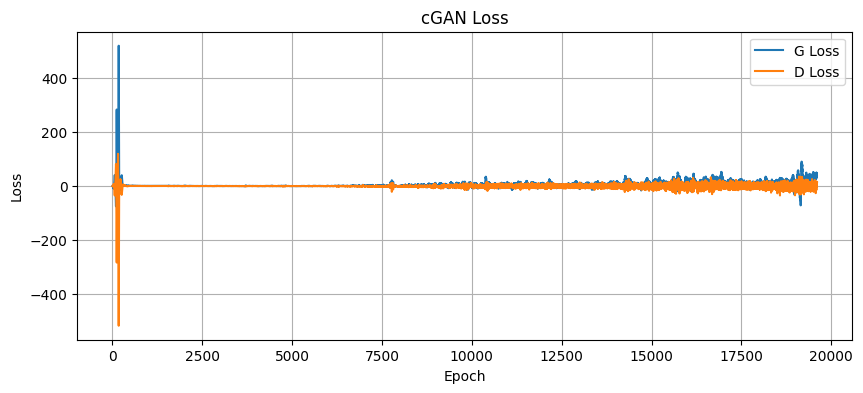

In [0]:
# Creating a DataFrame from the losses
loss_data = pd.DataFrame({
    'Generator Loss': gen_losses,
    'Discriminator Loss': disc_losses
})
# Convert all the tensor values to floats
loss_data['Generator Loss'] = loss_data['Generator Loss'].apply(lambda x: x.numpy() if isinstance(x, tf.Tensor) else x)
loss_data['Discriminator Loss'] = loss_data['Discriminator Loss'].apply(lambda x: x.numpy() if isinstance(x, tf.Tensor) else x)
# Save the DataFrame as a CSV or log it as an artifact in MLflow
loss_data.to_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_tf.csv")
mlflow.log_artifact("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_tf.csv")

# Plot the loss.
fig, ax = plt.subplots(figsize=(10, 4))
loss_data.plot(ax=ax)
plt.title('cGAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['G Loss', 'D Loss'])
plt.grid(True)

# Make sure to use a correct path to save the plot.
plot_path =  "/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot_tf.png"
plt.savefig(plot_path)

## Integrating the Training Step: Epoch Level Loss

In [0]:
# Initialize lists to store the mean losses for each epoch
mean_gen_losses = []
mean_disc_losses = []

for epoch in range(epochs):
    # Initialize lists to store losses for each batch
    batch_gen_losses = []
    batch_disc_losses = []
    
    for real_data, classes in dataset:
        # Perform the training step and get the losses
        gen_loss, disc_loss = train_step(real_data, classes, generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size, noise_dim)
        
        # Append the losses to the batch-specific lists
        batch_gen_losses.append(gen_loss.numpy())  # Convert to numpy if it's a tensor
        batch_disc_losses.append(disc_loss.numpy())
        
    # Calculate the mean losses for the epoch
    epoch_gen_loss = np.mean(batch_gen_losses)
    epoch_disc_loss = np.mean(batch_disc_losses)
    
    # Log the mean losses for the epoch
    mlflow.log_metric("Generator Loss", epoch_gen_loss, step=epoch)
    mlflow.log_metric("Discriminator Loss", epoch_disc_loss, step=epoch)
    
    # Append the mean losses to the epoch-specific lists
    mean_gen_losses.append(epoch_gen_loss)
    mean_disc_losses.append(epoch_disc_loss)
    
    # Log the mean losses for monitoring
    print(f"Epoch: {epoch}, Mean Generator Loss: {epoch_gen_loss}, Mean Discriminator Loss: {epoch_disc_loss}")

Epoch: 0, Mean Generator Loss: 16.835887908935547, Mean Discriminator Loss: 0.5890781879425049
Epoch: 1, Mean Generator Loss: 12.778507232666016, Mean Discriminator Loss: -0.4515567719936371
Epoch: 2, Mean Generator Loss: 22.116884231567383, Mean Discriminator Loss: -1.2316889762878418
Epoch: 3, Mean Generator Loss: 19.47618293762207, Mean Discriminator Loss: -0.8731077313423157
Epoch: 4, Mean Generator Loss: 25.691789627075195, Mean Discriminator Loss: -0.5379351377487183
Epoch: 5, Mean Generator Loss: 17.224470138549805, Mean Discriminator Loss: -0.020078834146261215
Epoch: 6, Mean Generator Loss: 23.575170516967773, Mean Discriminator Loss: -1.3520432710647583
Epoch: 7, Mean Generator Loss: 40.300453186035156, Mean Discriminator Loss: -0.7049715518951416
Epoch: 8, Mean Generator Loss: 11.095524787902832, Mean Discriminator Loss: 0.6349419355392456
Epoch: 9, Mean Generator Loss: 12.051127433776855, Mean Discriminator Loss: -0.3666296899318695
Epoch: 10, Mean Generator Loss: 13.506093